In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torch.nn.functional import relu

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joelacht","key":"77a0a18e3f8f5f83cb7a1363836b23d8"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d quadeer15sh/augmented-forest-segmentation

Dataset URL: https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation
License(s): other
 74% 128M/172M [00:00<00:00, 1.34GB/s]
100% 172M/172M [00:00<00:00, 1.35GB/s]


In [7]:
!mkdir augmented-forest-segmentation

In [8]:
!unzip augmented-forest-segmentation.zip -d augmented-forest-segmentation

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_73.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_77.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_78.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_80.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_81.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_87.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/119079_mask_88.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/122104_mask_00.jpg  
  inflating: augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks/122104_mask_01.jp

In [9]:
import pandas as pd

meta_data = pd.read_csv("augmented-forest-segmentation/Forest Segmented/Forest Segmented/meta_data.csv")
print(meta_data.head())
print(meta_data.columns)

               image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg
Index(['image', 'mask'], dtype='object')


In [10]:
class ForestDataset(Dataset):
    def __init__(self, images_dir, masks_dir, meta_csv, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.meta = pd.read_csv(meta_csv)
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        img_name = self.meta.iloc[idx]["image"]
        mask_name = self.meta.iloc[idx]["mask"]

        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        mask = mask.unsqueeze(0).float() / 255.0  # (1,H,W)
        return image, mask

In [11]:
# --------------------
# 3. U-Net (упрощённая)
# --------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bridge = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        bridge = self.bridge(p2)

        u2 = self.up2(bridge)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))

        return torch.sigmoid(self.final(c1))

In [12]:
transform_train = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

transform_val = A.Compose([
    A.Resize(128, 128),
    A.Normalize(),
    ToTensorV2()
])

In [13]:
dataset = ForestDataset("augmented-forest-segmentation/Forest Segmented/Forest Segmented/images", "augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks",
                        meta_csv="augmented-forest-segmentation/Forest Segmented/Forest Segmented/meta_data.csv", transform=transform_train)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Валидации нужны только свои трансформации
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Device: cuda


In [15]:
def accuracy(preds, targets):
    preds = (preds > 0.5).float()
    correct = (preds == targets).float().sum()
    return correct / targets.numel()

def iou(preds, targets, eps=1e-6):
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + eps) / (union + eps)

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, preds, targets):
        preds = preds.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.eps) / (preds.sum() + targets.sum() + self.eps)
        return 1 - dice

dice_loss_fn = DiceLoss()

In [17]:
import torch.nn.functional as F

Epoch 1/10 | Train BCE: 0.539, Val BCE: 0.462, Train Dice: 0.262, Val Dice: 0.258, Train Combo: 0.801, Val Combo: 0.720, Train Acc: 0.747, Val Acc: 0.787, Train IoU: 0.676, Val IoU: 0.711)


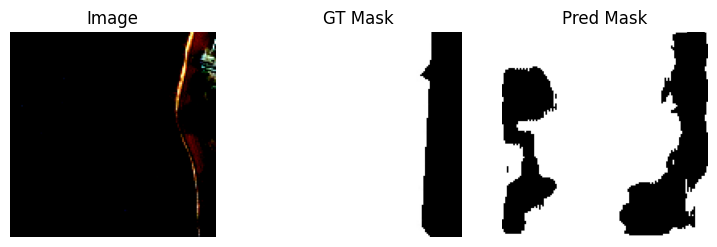

Epoch 2/10 | Train BCE: 0.506, Val BCE: 0.450, Train Dice: 0.240, Val Dice: 0.206, Train Combo: 0.745, Val Combo: 0.657, Train Acc: 0.768, Val Acc: 0.799, Train IoU: 0.701, Val IoU: 0.740)


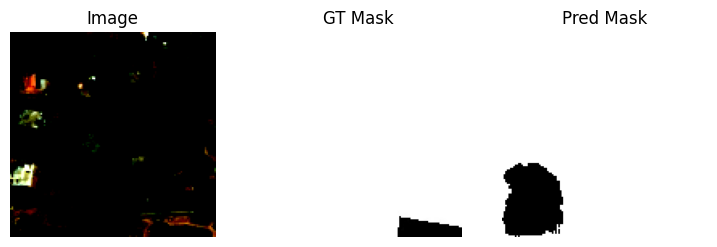

Epoch 3/10 | Train BCE: 0.492, Val BCE: 0.429, Train Dice: 0.232, Val Dice: 0.212, Train Combo: 0.724, Val Combo: 0.641, Train Acc: 0.775, Val Acc: 0.805, Train IoU: 0.709, Val IoU: 0.746)


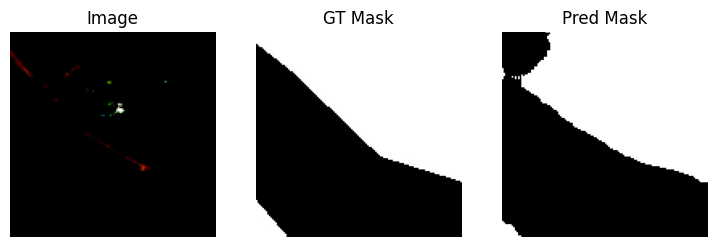

Epoch 4/10 | Train BCE: 0.482, Val BCE: 0.422, Train Dice: 0.226, Val Dice: 0.197, Train Combo: 0.708, Val Combo: 0.619, Train Acc: 0.781, Val Acc: 0.811, Train IoU: 0.715, Val IoU: 0.753)


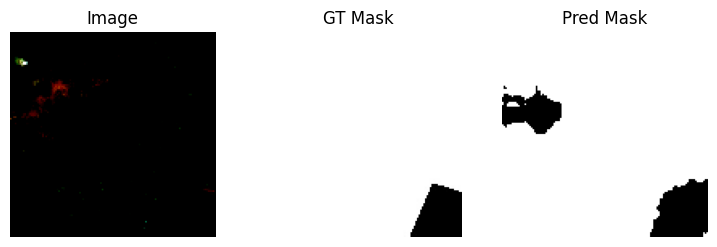

Epoch 5/10 | Train BCE: 0.476, Val BCE: 0.425, Train Dice: 0.223, Val Dice: 0.215, Train Combo: 0.699, Val Combo: 0.639, Train Acc: 0.784, Val Acc: 0.804, Train IoU: 0.717, Val IoU: 0.737)


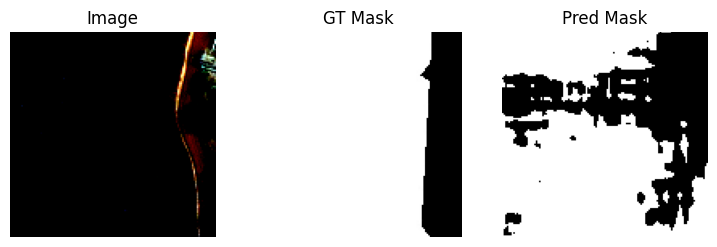

Epoch 6/10 | Train BCE: 0.470, Val BCE: 0.459, Train Dice: 0.220, Val Dice: 0.239, Train Combo: 0.690, Val Combo: 0.698, Train Acc: 0.788, Val Acc: 0.789, Train IoU: 0.721, Val IoU: 0.712)


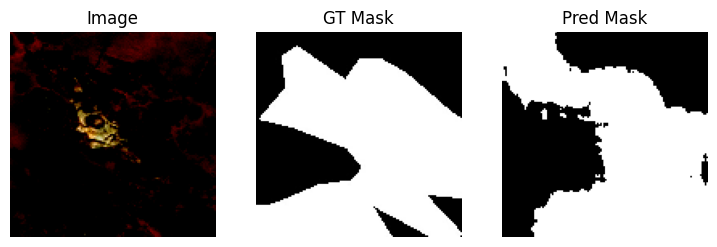

Epoch 7/10 | Train BCE: 0.467, Val BCE: 0.438, Train Dice: 0.218, Val Dice: 0.259, Train Combo: 0.685, Val Combo: 0.697, Train Acc: 0.790, Val Acc: 0.802, Train IoU: 0.723, Val IoU: 0.728)


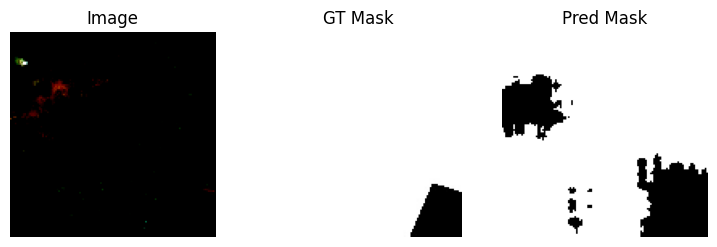

Epoch 8/10 | Train BCE: 0.464, Val BCE: 0.431, Train Dice: 0.217, Val Dice: 0.253, Train Combo: 0.681, Val Combo: 0.683, Train Acc: 0.792, Val Acc: 0.812, Train IoU: 0.726, Val IoU: 0.747)


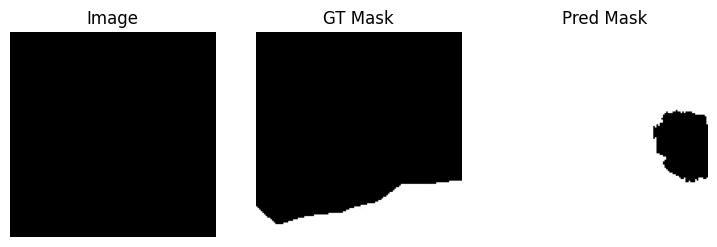

Epoch 9/10 | Train BCE: 0.460, Val BCE: 0.422, Train Dice: 0.215, Val Dice: 0.234, Train Combo: 0.675, Val Combo: 0.656, Train Acc: 0.794, Val Acc: 0.810, Train IoU: 0.728, Val IoU: 0.740)


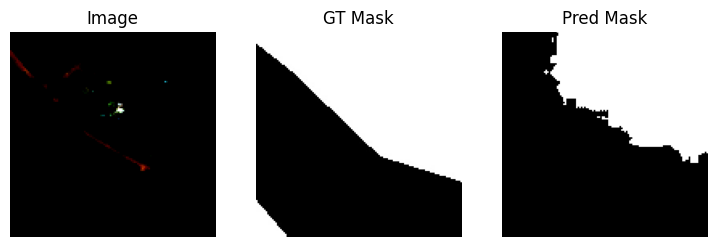

Epoch 10/10 | Train BCE: 0.453, Val BCE: 0.411, Train Dice: 0.211, Val Dice: 0.200, Train Combo: 0.664, Val Combo: 0.612, Train Acc: 0.796, Val Acc: 0.814, Train IoU: 0.730, Val IoU: 0.758)


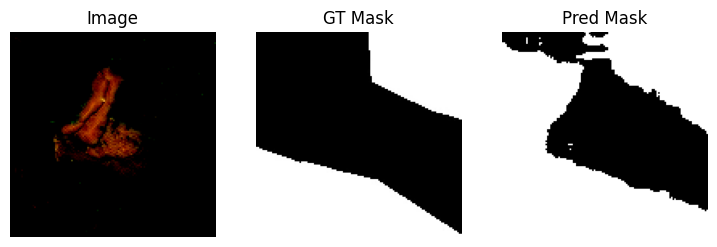

In [18]:
log = dict()
for key in [
    "epoch_train_bce", "epoch_valid_bce",
    "epoch_train_dice", "epoch_valid_dice",
    "epoch_train_combo", "epoch_valid_combo",
    "epoch_train_accuracy", "epoch_valid_accuracy",
    "epoch_train_iou", "epoch_valid_iou"
]:
    log[key] = []

# --- цикл ---
EPOCHS = 10
for epoch in range(EPOCHS):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)

        # лоссы
        bce = F.binary_cross_entropy(preds, masks)
        dice = dice_loss_fn(preds, masks)
        combo = bce + dice

        optimizer.zero_grad()
        combo.backward()   # оптимизируем по комбинированному
        optimizer.step()

        # метрики
        acc = accuracy(preds, masks).item()
        iou_score = iou(preds, masks).item()

        batch_bce.append(bce.item())
        batch_dice.append(dice.item())
        batch_combo.append(combo.item())
        batch_acc.append(acc)
        batch_iou.append(iou_score)

    log["epoch_train_bce"].append(np.mean(batch_bce))
    log["epoch_train_dice"].append(np.mean(batch_dice))
    log["epoch_train_combo"].append(np.mean(batch_combo))
    log["epoch_train_accuracy"].append(np.mean(batch_acc))
    log["epoch_train_iou"].append(np.mean(batch_iou))

    # -------------------
    # VALID
    # -------------------
    model.eval()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            bce = F.binary_cross_entropy(preds, masks)
            dice = dice_loss_fn(preds, masks)
            combo = bce + dice

            acc = accuracy(preds, masks).item()
            iou_score = iou(preds, masks).item()

            batch_bce.append(bce.item())
            batch_dice.append(dice.item())
            batch_combo.append(combo.item())
            batch_acc.append(acc)
            batch_iou.append(iou_score)

    log["epoch_valid_bce"].append(np.mean(batch_bce))
    log["epoch_valid_dice"].append(np.mean(batch_dice))
    log["epoch_valid_combo"].append(np.mean(batch_combo))
    log["epoch_valid_accuracy"].append(np.mean(batch_acc))
    log["epoch_valid_iou"].append(np.mean(batch_iou))

    # -------------------
    # PRINT
    # -------------------
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train BCE: {log['epoch_train_bce'][-1]:.3f}, "
          f"Val BCE: {log['epoch_valid_bce'][-1]:.3f}, "
          f"Train Dice: {log['epoch_train_dice'][-1]:.3f}, "
          f"Val Dice: {log['epoch_valid_dice'][-1]:.3f}, "
          f"Train Combo: {log['epoch_train_combo'][-1]:.3f}, "
          f"Val Combo: {log['epoch_valid_combo'][-1]:.3f}, "
          f"Train Acc: {log['epoch_train_accuracy'][-1]:.3f}, "
          f"Val Acc: {log['epoch_valid_accuracy'][-1]:.3f}, "
          f"Train IoU: {log['epoch_train_iou'][-1]:.3f}, "
          f"Val IoU: {log['epoch_valid_iou'][-1]:.3f})")

    model.eval()
    with torch.no_grad():
        images_v, masks_v = next(iter(val_loader))
        images_v = images_v.to(device)
        preds_v = model(images_v)

    k = np.random.randint(0, images_v.size(0))
    img = images_v[k].permute(1,2,0).cpu().numpy()
    mask_gt = masks_v[k].squeeze().cpu().numpy()
    mask_pr = (preds_v[k].squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask_gt, cmap="gray"); plt.title("GT Mask"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask_pr, cmap="gray"); plt.title("Pred Mask"); plt.axis("off")
    plt.show()

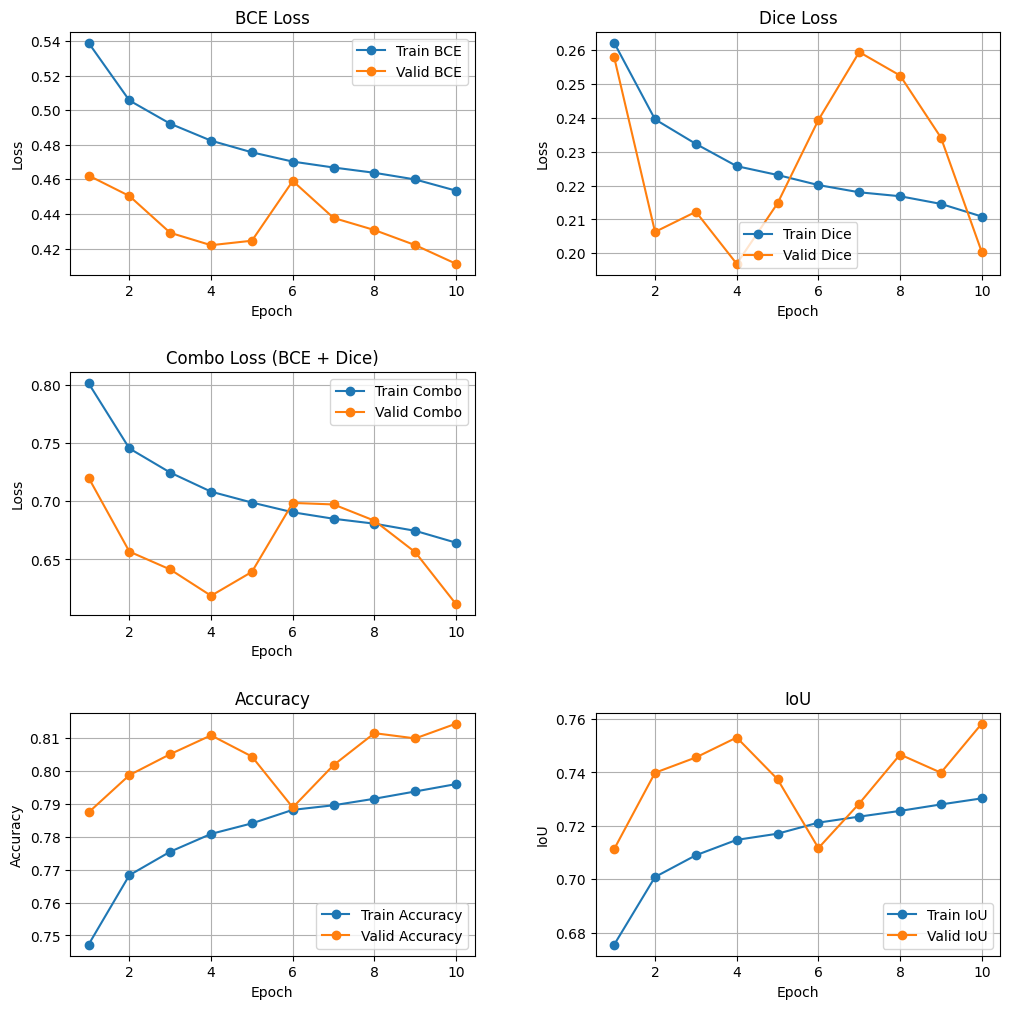

In [19]:
epochs = range(1, len(log['epoch_train_bce']) + 1)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------
# 1 строка: BCE и Dice
# -----------------------------
# BCE
axes[0, 0].plot(epochs, log['epoch_train_bce'], label='Train BCE', marker='o')
axes[0, 0].plot(epochs, log['epoch_valid_bce'], label='Valid BCE', marker='o')
axes[0, 0].set_title("BCE Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Dice
axes[0, 1].plot(epochs, log['epoch_train_dice'], label='Train Dice', marker='o')
axes[0, 1].plot(epochs, log['epoch_valid_dice'], label='Valid Dice', marker='o')
axes[0, 1].set_title("Dice Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# -----------------------------
# 2 строка: Combo (занимает всю строку)
# -----------------------------
# Чтобы занять всю строку, объединим два графика axes[1,0] и axes[1,1]
fig.delaxes(axes[1,1])  # удаляем пустой график справа
axes[1,0].plot(epochs, log['epoch_train_combo'], label='Train Combo', marker='o')
axes[1,0].plot(epochs, log['epoch_valid_combo'], label='Valid Combo', marker='o')
axes[1,0].set_title("Combo Loss (BCE + Dice)")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# -----------------------------
# 3 строка: Accuracy и IoU
# -----------------------------
# Accuracy
axes[2, 0].plot(epochs, log['epoch_train_accuracy'], label='Train Accuracy', marker='o')
axes[2, 0].plot(epochs, log['epoch_valid_accuracy'], label='Valid Accuracy', marker='o')
axes[2, 0].set_title("Accuracy")
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Accuracy")
axes[2, 0].legend()
axes[2, 0].grid(True)

# IoU
axes[2, 1].plot(epochs, log['epoch_train_iou'], label='Train IoU', marker='o')
axes[2, 1].plot(epochs, log['epoch_valid_iou'], label='Valid IoU', marker='o')
axes[2, 1].set_title("IoU")
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.show()

In [20]:
torch.save(model.state_dict(), "unet_last_epoch.pth")

In [21]:
model.load_state_dict(torch.load("unet_last_epoch.pth"))

<All keys matched successfully>

Epoch 1: Сохранили лучшую модель! Val Combo: 0.6654
Epoch 1/20 | Train BCE: 0.454, Val BCE: 0.436, Train Dice: 0.213, Val Dice: 0.230, Train Combo: 0.667, Val Combo: 0.665, Train Acc: 0.796, Val Acc: 0.807, Train IoU: 0.729, Val IoU: 0.735)


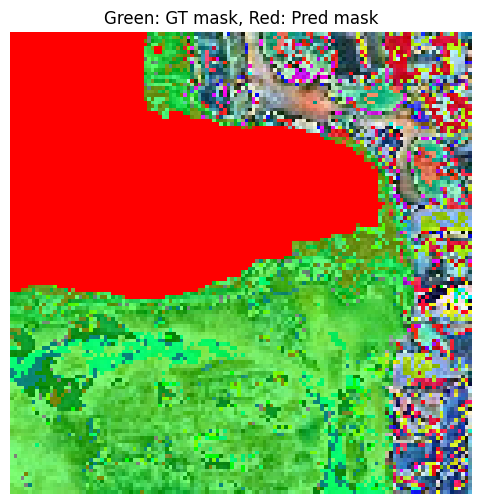

Epoch 2: Сохранили лучшую модель! Val Combo: 0.5948
Epoch 2/20 | Train BCE: 0.448, Val BCE: 0.398, Train Dice: 0.210, Val Dice: 0.197, Train Combo: 0.658, Val Combo: 0.595, Train Acc: 0.799, Val Acc: 0.821, Train IoU: 0.733, Val IoU: 0.762)


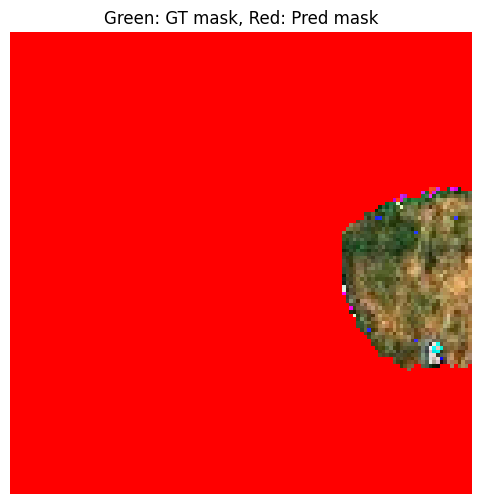

Epoch 3/20 | Train BCE: 0.445, Val BCE: 0.407, Train Dice: 0.208, Val Dice: 0.188, Train Combo: 0.653, Val Combo: 0.595, Train Acc: 0.799, Val Acc: 0.821, Train IoU: 0.734, Val IoU: 0.761)


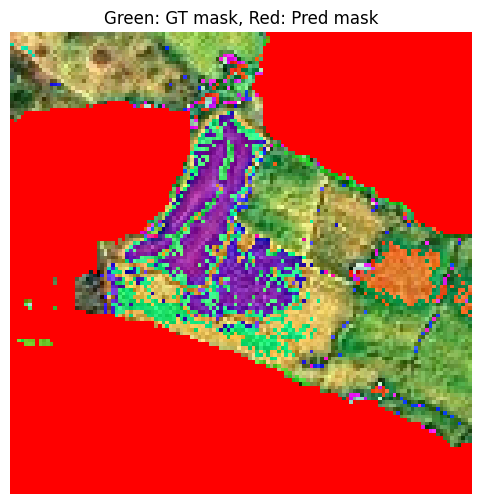

Epoch 4/20 | Train BCE: 0.444, Val BCE: 0.399, Train Dice: 0.206, Val Dice: 0.208, Train Combo: 0.650, Val Combo: 0.607, Train Acc: 0.801, Val Acc: 0.817, Train IoU: 0.736, Val IoU: 0.753)


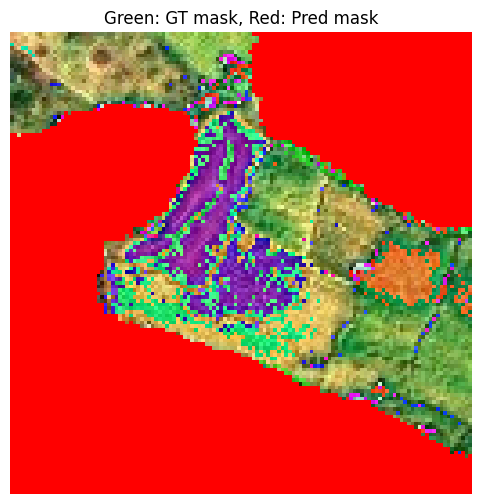

Epoch 5: Сохранили лучшую модель! Val Combo: 0.5862
Epoch 5/20 | Train BCE: 0.443, Val BCE: 0.403, Train Dice: 0.206, Val Dice: 0.184, Train Combo: 0.649, Val Combo: 0.586, Train Acc: 0.802, Val Acc: 0.821, Train IoU: 0.737, Val IoU: 0.768)


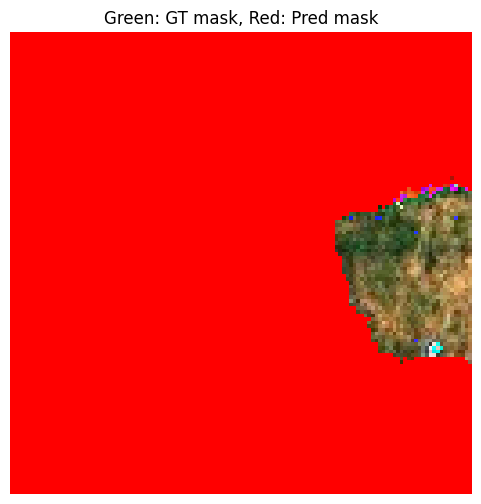

Epoch 6/20 | Train BCE: 0.436, Val BCE: 0.411, Train Dice: 0.203, Val Dice: 0.200, Train Combo: 0.639, Val Combo: 0.612, Train Acc: 0.804, Val Acc: 0.814, Train IoU: 0.738, Val IoU: 0.756)


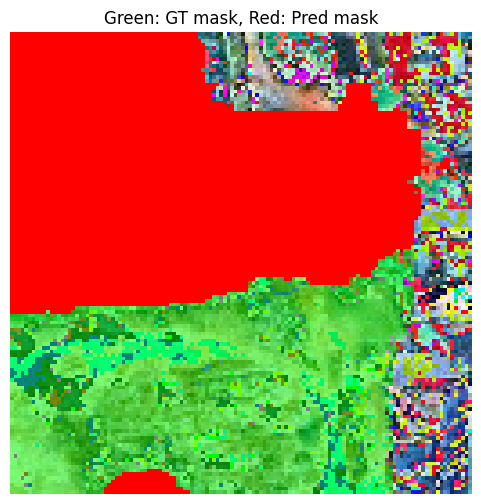

Epoch 7/20 | Train BCE: 0.436, Val BCE: 0.405, Train Dice: 0.203, Val Dice: 0.213, Train Combo: 0.639, Val Combo: 0.618, Train Acc: 0.805, Val Acc: 0.816, Train IoU: 0.740, Val IoU: 0.743)


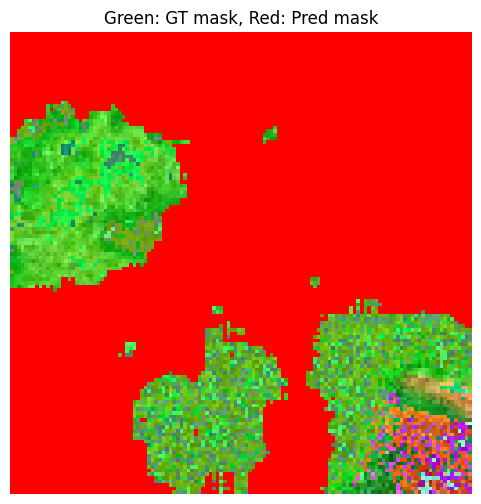

Epoch 8/20 | Train BCE: 0.434, Val BCE: 0.420, Train Dice: 0.203, Val Dice: 0.194, Train Combo: 0.637, Val Combo: 0.614, Train Acc: 0.806, Val Acc: 0.808, Train IoU: 0.741, Val IoU: 0.759)


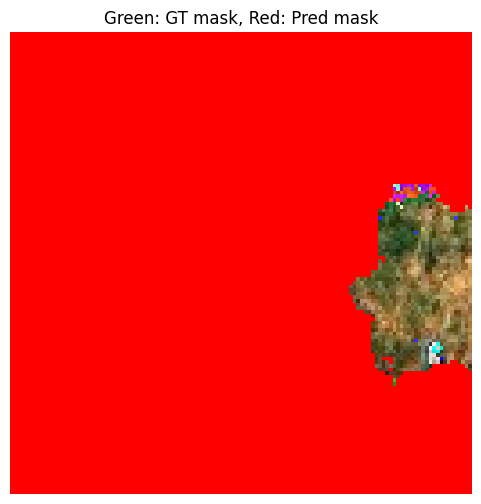

Epoch 9: Сохранили лучшую модель! Val Combo: 0.5794
Epoch 9/20 | Train BCE: 0.432, Val BCE: 0.392, Train Dice: 0.200, Val Dice: 0.188, Train Combo: 0.632, Val Combo: 0.579, Train Acc: 0.808, Val Acc: 0.823, Train IoU: 0.744, Val IoU: 0.768)


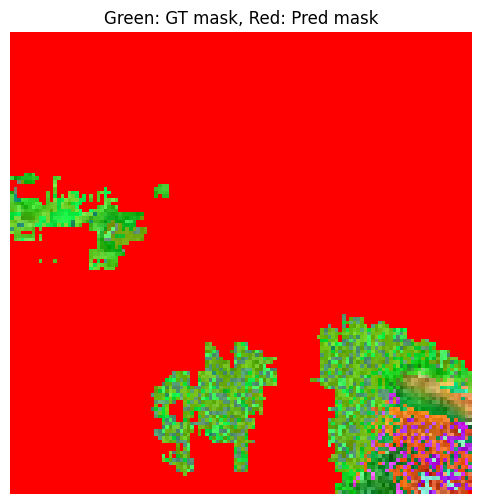

Epoch 10/20 | Train BCE: 0.429, Val BCE: 0.413, Train Dice: 0.200, Val Dice: 0.192, Train Combo: 0.629, Val Combo: 0.605, Train Acc: 0.808, Val Acc: 0.816, Train IoU: 0.742, Val IoU: 0.759)


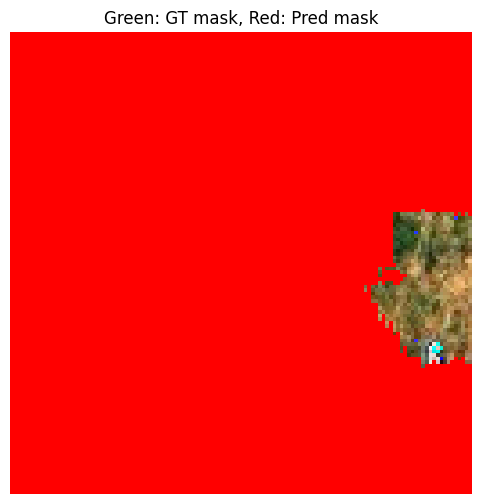

Epoch 11: Сохранили лучшую модель! Val Combo: 0.5759
Epoch 11/20 | Train BCE: 0.429, Val BCE: 0.387, Train Dice: 0.200, Val Dice: 0.189, Train Combo: 0.629, Val Combo: 0.576, Train Acc: 0.809, Val Acc: 0.824, Train IoU: 0.743, Val IoU: 0.772)


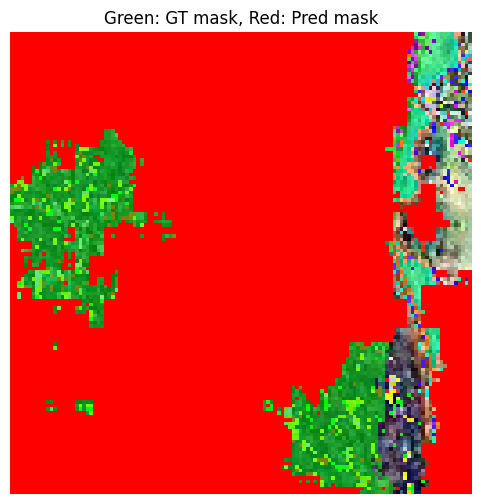

Epoch 12/20 | Train BCE: 0.424, Val BCE: 0.380, Train Dice: 0.197, Val Dice: 0.203, Train Combo: 0.621, Val Combo: 0.583, Train Acc: 0.811, Val Acc: 0.831, Train IoU: 0.746, Val IoU: 0.774)


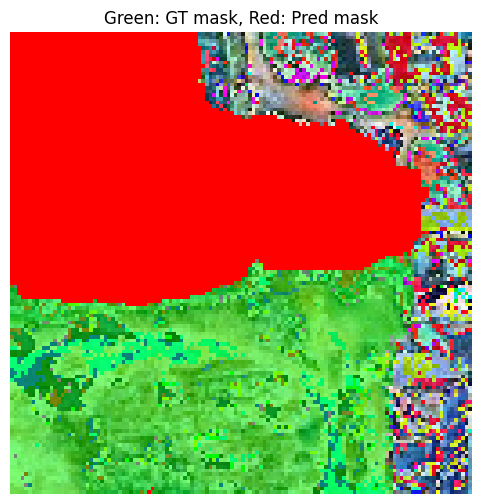

Epoch 13/20 | Train BCE: 0.427, Val BCE: 0.385, Train Dice: 0.200, Val Dice: 0.203, Train Combo: 0.627, Val Combo: 0.588, Train Acc: 0.809, Val Acc: 0.827, Train IoU: 0.744, Val IoU: 0.770)


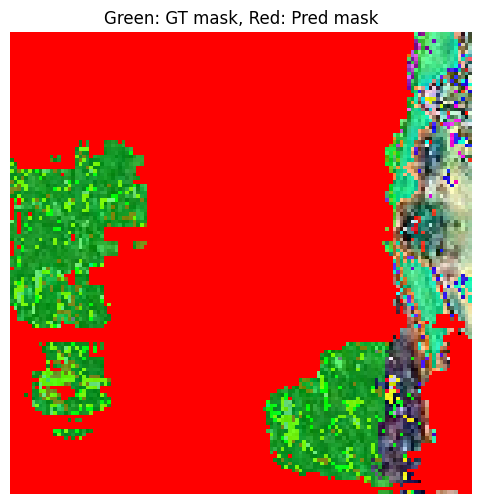

Epoch 14: Сохранили лучшую модель! Val Combo: 0.5738
Epoch 14/20 | Train BCE: 0.423, Val BCE: 0.397, Train Dice: 0.198, Val Dice: 0.177, Train Combo: 0.622, Val Combo: 0.574, Train Acc: 0.810, Val Acc: 0.825, Train IoU: 0.744, Val IoU: 0.767)


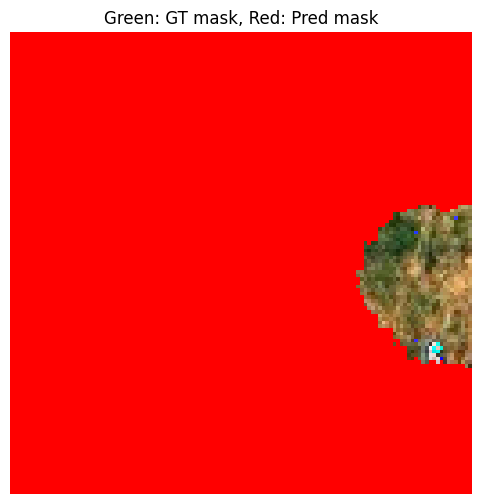

Epoch 15: Сохранили лучшую модель! Val Combo: 0.5727
Epoch 15/20 | Train BCE: 0.421, Val BCE: 0.384, Train Dice: 0.196, Val Dice: 0.189, Train Combo: 0.616, Val Combo: 0.573, Train Acc: 0.812, Val Acc: 0.825, Train IoU: 0.748, Val IoU: 0.772)


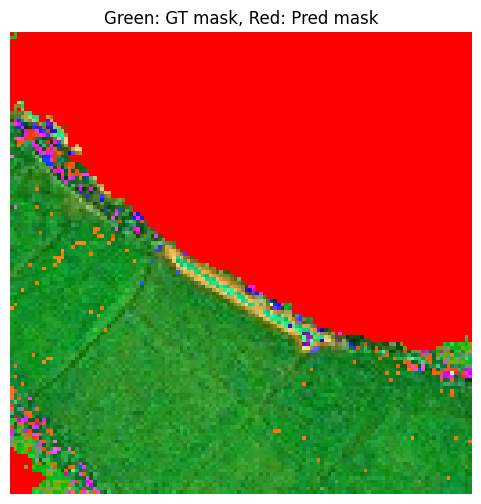

Epoch 16: Сохранили лучшую модель! Val Combo: 0.5642
Epoch 16/20 | Train BCE: 0.421, Val BCE: 0.384, Train Dice: 0.195, Val Dice: 0.180, Train Combo: 0.616, Val Combo: 0.564, Train Acc: 0.812, Val Acc: 0.828, Train IoU: 0.748, Val IoU: 0.773)


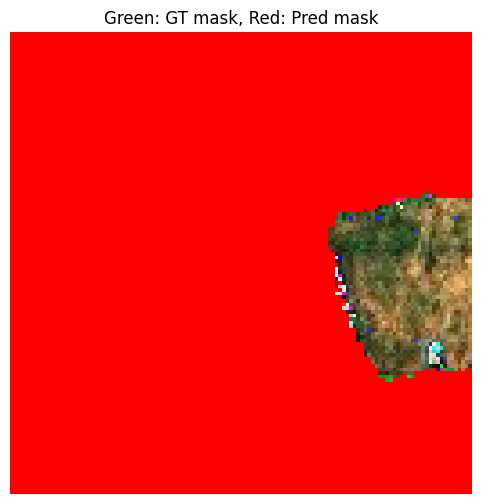

Epoch 17: Сохранили лучшую модель! Val Combo: 0.5529
Epoch 17/20 | Train BCE: 0.417, Val BCE: 0.374, Train Dice: 0.194, Val Dice: 0.179, Train Combo: 0.612, Val Combo: 0.553, Train Acc: 0.814, Val Acc: 0.832, Train IoU: 0.748, Val IoU: 0.776)


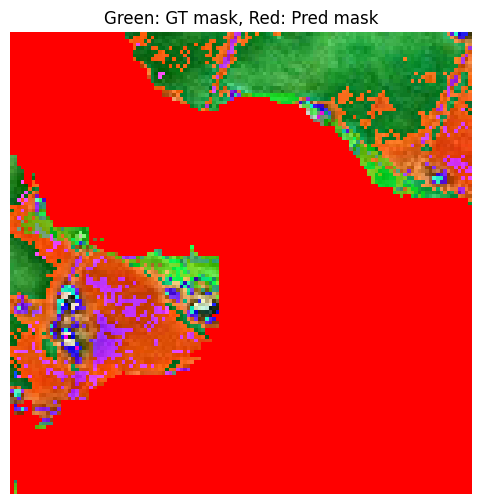

Epoch 18/20 | Train BCE: 0.414, Val BCE: 0.381, Train Dice: 0.194, Val Dice: 0.199, Train Combo: 0.609, Val Combo: 0.581, Train Acc: 0.815, Val Acc: 0.827, Train IoU: 0.749, Val IoU: 0.764)


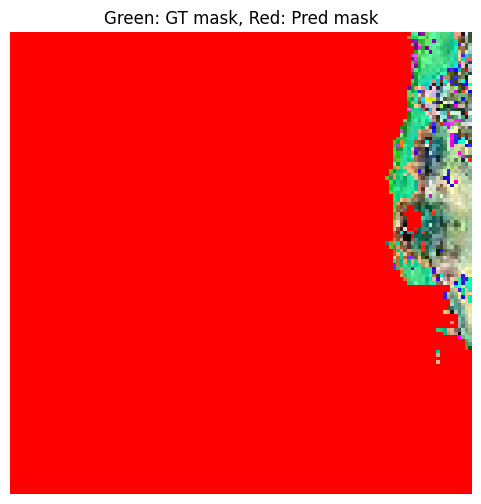

Epoch 19/20 | Train BCE: 0.414, Val BCE: 0.385, Train Dice: 0.192, Val Dice: 0.178, Train Combo: 0.606, Val Combo: 0.564, Train Acc: 0.816, Val Acc: 0.830, Train IoU: 0.751, Val IoU: 0.773)


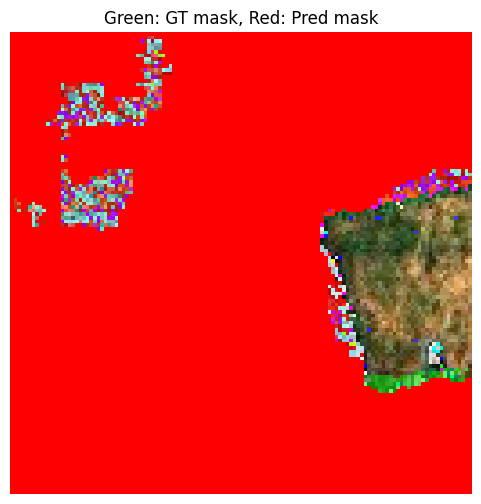

Epoch 20/20 | Train BCE: 0.412, Val BCE: 0.386, Train Dice: 0.191, Val Dice: 0.194, Train Combo: 0.603, Val Combo: 0.580, Train Acc: 0.816, Val Acc: 0.827, Train IoU: 0.752, Val IoU: 0.766)


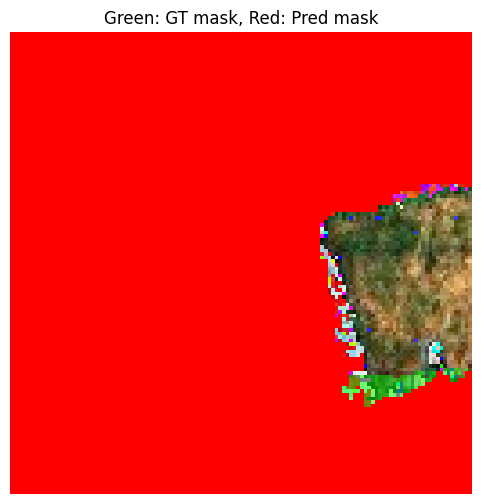

In [22]:
EPOCHS = 20  # например, продолжаем до 20 эпох
best_val_combo = float('inf')  # начальное значение для лучшей модели

# Папка для сохранения
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(EPOCHS):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)

        bce = F.binary_cross_entropy(preds, masks)
        dice = DiceLoss()(preds, masks)
        combo = bce + dice

        optimizer.zero_grad()
        combo.backward()
        optimizer.step()

        batch_bce.append(bce.item())
        batch_dice.append(dice.item())
        batch_combo.append(combo.item())
        batch_acc.append(accuracy(preds, masks).item())
        batch_iou.append(iou(preds, masks).item())

    log["epoch_train_bce"].append(np.mean(batch_bce))
    log["epoch_train_dice"].append(np.mean(batch_dice))
    log["epoch_train_combo"].append(np.mean(batch_combo))
    log["epoch_train_accuracy"].append(np.mean(batch_acc))
    log["epoch_train_iou"].append(np.mean(batch_iou))

    # -------------------
    # VALID
    # -------------------
    model.eval()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            bce = F.binary_cross_entropy(preds, masks)
            dice = DiceLoss()(preds, masks)
            combo = bce + dice

            batch_bce.append(bce.item())
            batch_dice.append(dice.item())
            batch_combo.append(combo.item())
            batch_acc.append(accuracy(preds, masks).item())
            batch_iou.append(iou(preds, masks).item())

    val_combo_epoch = np.mean(batch_combo)

    log["epoch_valid_bce"].append(np.mean(batch_bce))
    log["epoch_valid_dice"].append(np.mean(batch_dice))
    log["epoch_valid_combo"].append(val_combo_epoch)
    log["epoch_valid_accuracy"].append(np.mean(batch_acc))
    log["epoch_valid_iou"].append(np.mean(batch_iou))

    # -------------------
    # Сохраняем лучшую модель
    # -------------------
    if val_combo_epoch < best_val_combo:
        best_val_combo = val_combo_epoch
        torch.save(model.state_dict(), f"checkpoints/best_unet.pth")
        print(f"Epoch {epoch+1}: Сохранили лучшую модель! Val Combo: {best_val_combo:.4f}")

    # -------------------
    # PRINT
    # -------------------
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train BCE: {log['epoch_train_bce'][-1]:.3f}, Val BCE: {log['epoch_valid_bce'][-1]:.3f}, "
          f"Train Dice: {log['epoch_train_dice'][-1]:.3f}, Val Dice: {log['epoch_valid_dice'][-1]:.3f}, "
          f"Train Combo: {log['epoch_train_combo'][-1]:.3f}, Val Combo: {log['epoch_valid_combo'][-1]:.3f}, "
          f"Train Acc: {log['epoch_train_accuracy'][-1]:.3f}, Val Acc: {log['epoch_valid_accuracy'][-1]:.3f}, "
          f"Train IoU: {log['epoch_train_iou'][-1]:.3f}, Val IoU: {log['epoch_valid_iou'][-1]:.3f})")

    model.eval()
    with torch.no_grad():
        images_v, masks_v = next(iter(val_loader))
        images_v = images_v.to(device)
        masks_v = masks_v.to(device)
        preds_v = model(images_v)

    k = np.random.randint(0, images_v.size(0))

    # Де-нормализуем изображение
    img = images_v[k].permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Маски
    mask_gt = masks_v[k].squeeze().cpu().numpy()       # 0 или 1
    mask_pr = (preds_v[k].squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # Создаем RGB копию для наложения
    overlay = img.copy()

    # Наложение GT — зеленый
    overlay[mask_gt==1] = [0, 255, 0]

    # Наложение Pred — красный (можно с прозрачностью)
    alpha = 0.5
    overlay = cv2.addWeighted(img, 1-alpha, overlay, alpha, 0)

    # Наложение Pred — красный
    overlay[mask_pr==1] = [255, 0, 0]

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Green: GT mask, Red: Pred mask")
    plt.show()

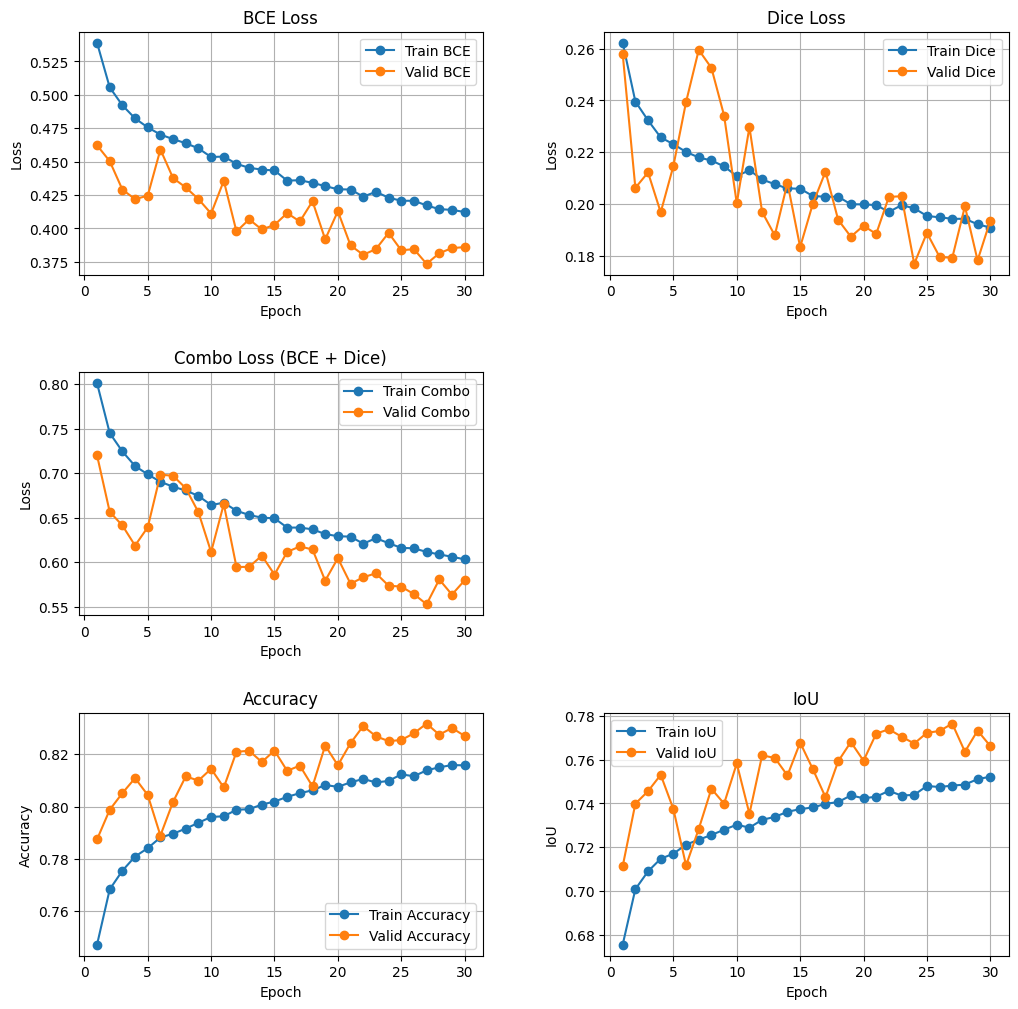

In [23]:
epochs = range(1, len(log['epoch_train_bce']) + 1)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------
# 1 строка: BCE и Dice
# -----------------------------
# BCE
axes[0, 0].plot(epochs, log['epoch_train_bce'], label='Train BCE', marker='o')
axes[0, 0].plot(epochs, log['epoch_valid_bce'], label='Valid BCE', marker='o')
axes[0, 0].set_title("BCE Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Dice
axes[0, 1].plot(epochs, log['epoch_train_dice'], label='Train Dice', marker='o')
axes[0, 1].plot(epochs, log['epoch_valid_dice'], label='Valid Dice', marker='o')
axes[0, 1].set_title("Dice Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# -----------------------------
# 2 строка: Combo (занимает всю строку)
# -----------------------------
# Чтобы занять всю строку, объединим два графика axes[1,0] и axes[1,1]
fig.delaxes(axes[1,1])  # удаляем пустой график справа
axes[1,0].plot(epochs, log['epoch_train_combo'], label='Train Combo', marker='o')
axes[1,0].plot(epochs, log['epoch_valid_combo'], label='Valid Combo', marker='o')
axes[1,0].set_title("Combo Loss (BCE + Dice)")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# -----------------------------
# 3 строка: Accuracy и IoU
# -----------------------------
# Accuracy
axes[2, 0].plot(epochs, log['epoch_train_accuracy'], label='Train Accuracy', marker='o')
axes[2, 0].plot(epochs, log['epoch_valid_accuracy'], label='Valid Accuracy', marker='o')
axes[2, 0].set_title("Accuracy")
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Accuracy")
axes[2, 0].legend()
axes[2, 0].grid(True)

# IoU
axes[2, 1].plot(epochs, log['epoch_train_iou'], label='Train IoU', marker='o')
axes[2, 1].plot(epochs, log['epoch_valid_iou'], label='Valid IoU', marker='o')
axes[2, 1].set_title("IoU")
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.show()

In [24]:
model.load_state_dict(torch.load("checkpoints/best_unet.pth"))

<All keys matched successfully>

Epoch 1: Сохранили лучшую модель! Val Combo: 0.5701
Epoch 1/20 | Train BCE: 0.415, Val BCE: 0.377, Train Dice: 0.191, Val Dice: 0.193, Train Combo: 0.607, Val Combo: 0.570, Train Acc: 0.816, Val Acc: 0.830, Train IoU: 0.753, Val IoU: 0.771)


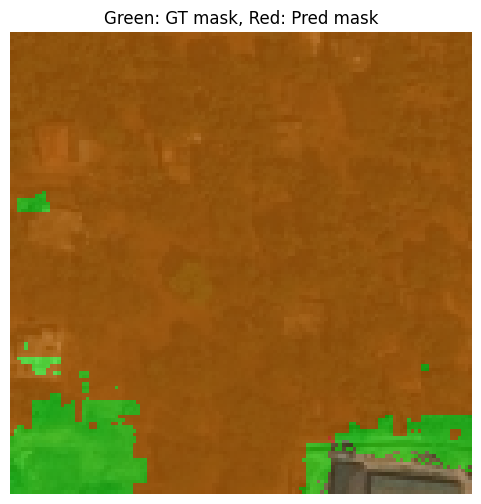

Epoch 2: Сохранили лучшую модель! Val Combo: 0.5642
Epoch 2/20 | Train BCE: 0.415, Val BCE: 0.389, Train Dice: 0.192, Val Dice: 0.175, Train Combo: 0.607, Val Combo: 0.564, Train Acc: 0.815, Val Acc: 0.828, Train IoU: 0.750, Val IoU: 0.776)


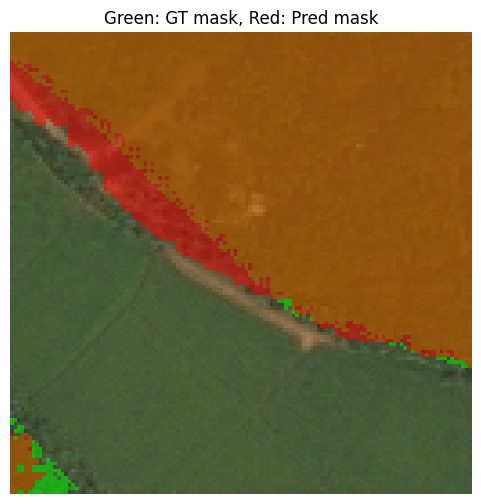

Epoch 3: Сохранили лучшую модель! Val Combo: 0.5617
Epoch 3/20 | Train BCE: 0.415, Val BCE: 0.379, Train Dice: 0.193, Val Dice: 0.183, Train Combo: 0.608, Val Combo: 0.562, Train Acc: 0.815, Val Acc: 0.831, Train IoU: 0.750, Val IoU: 0.775)


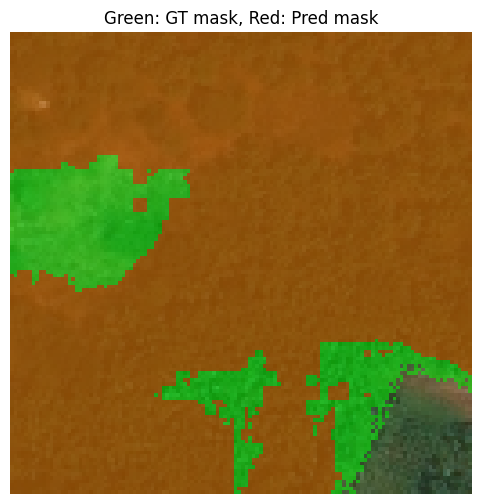

Epoch 4: Сохранили лучшую модель! Val Combo: 0.5597
Epoch 4/20 | Train BCE: 0.413, Val BCE: 0.376, Train Dice: 0.190, Val Dice: 0.184, Train Combo: 0.603, Val Combo: 0.560, Train Acc: 0.817, Val Acc: 0.831, Train IoU: 0.754, Val IoU: 0.771)


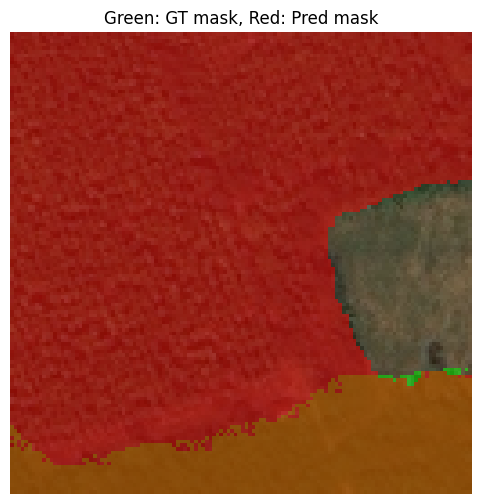

Epoch 5: Сохранили лучшую модель! Val Combo: 0.5588
Epoch 5/20 | Train BCE: 0.413, Val BCE: 0.381, Train Dice: 0.192, Val Dice: 0.177, Train Combo: 0.605, Val Combo: 0.559, Train Acc: 0.817, Val Acc: 0.831, Train IoU: 0.752, Val IoU: 0.776)


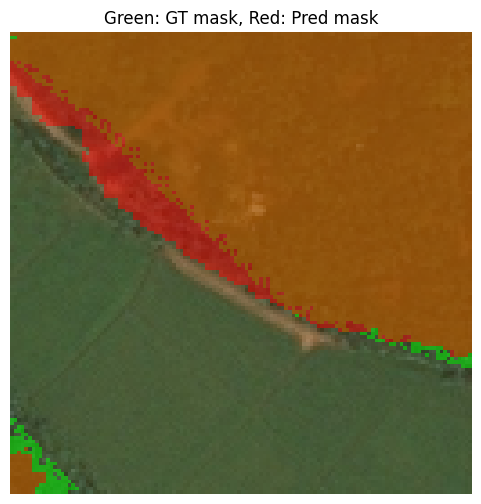

Epoch 6/20 | Train BCE: 0.410, Val BCE: 0.382, Train Dice: 0.189, Val Dice: 0.189, Train Combo: 0.600, Val Combo: 0.571, Train Acc: 0.818, Val Acc: 0.829, Train IoU: 0.754, Val IoU: 0.767)


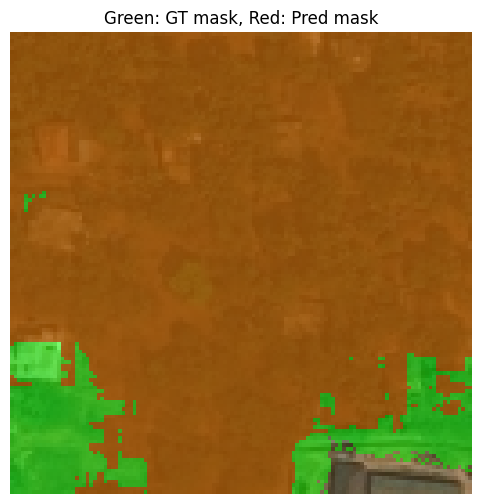

Epoch 7/20 | Train BCE: 0.406, Val BCE: 0.395, Train Dice: 0.188, Val Dice: 0.168, Train Combo: 0.594, Val Combo: 0.564, Train Acc: 0.820, Val Acc: 0.825, Train IoU: 0.756, Val IoU: 0.774)


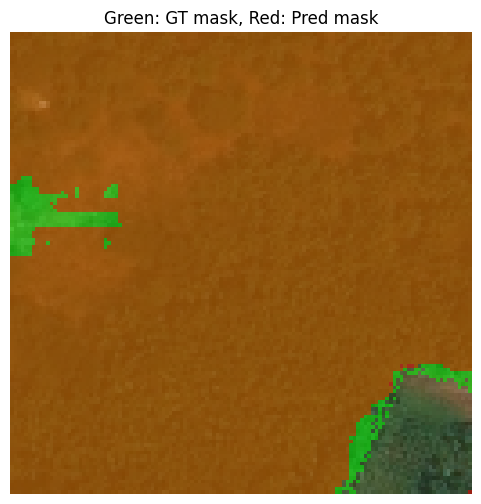

Epoch 8/20 | Train BCE: 0.403, Val BCE: 0.373, Train Dice: 0.185, Val Dice: 0.188, Train Combo: 0.588, Val Combo: 0.561, Train Acc: 0.822, Val Acc: 0.832, Train IoU: 0.759, Val IoU: 0.774)


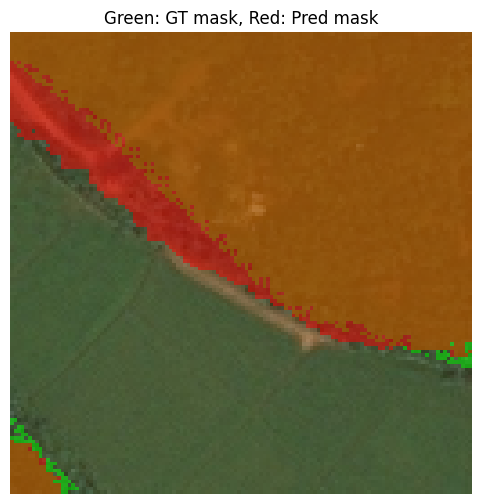

Epoch 9/20 | Train BCE: 0.406, Val BCE: 0.385, Train Dice: 0.187, Val Dice: 0.189, Train Combo: 0.593, Val Combo: 0.573, Train Acc: 0.819, Val Acc: 0.828, Train IoU: 0.756, Val IoU: 0.768)


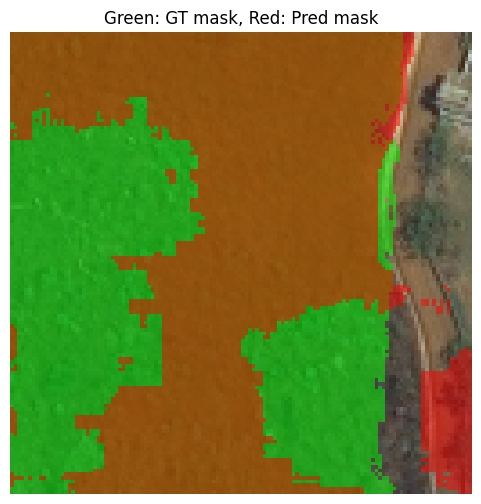

Epoch 10: Сохранили лучшую модель! Val Combo: 0.5521
Epoch 10/20 | Train BCE: 0.404, Val BCE: 0.380, Train Dice: 0.187, Val Dice: 0.172, Train Combo: 0.590, Val Combo: 0.552, Train Acc: 0.820, Val Acc: 0.831, Train IoU: 0.757, Val IoU: 0.776)


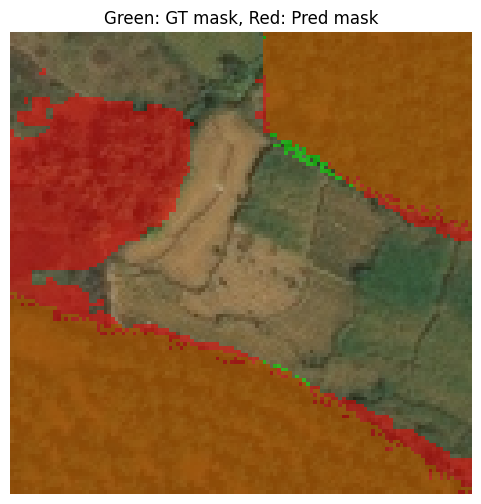

Epoch 11: Сохранили лучшую модель! Val Combo: 0.5509
Epoch 11/20 | Train BCE: 0.401, Val BCE: 0.380, Train Dice: 0.186, Val Dice: 0.171, Train Combo: 0.587, Val Combo: 0.551, Train Acc: 0.821, Val Acc: 0.830, Train IoU: 0.757, Val IoU: 0.777)


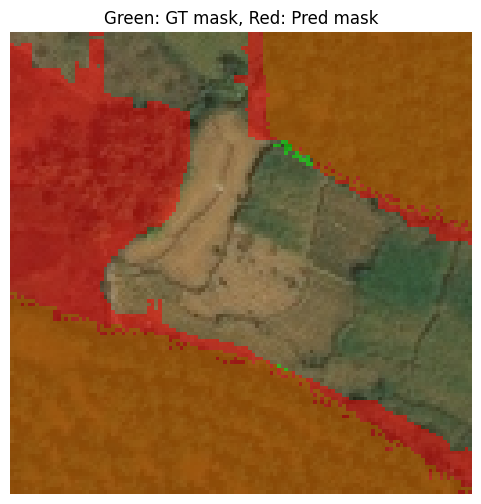

Epoch 12/20 | Train BCE: 0.397, Val BCE: 0.374, Train Dice: 0.183, Val Dice: 0.191, Train Combo: 0.580, Val Combo: 0.566, Train Acc: 0.825, Val Acc: 0.831, Train IoU: 0.762, Val IoU: 0.776)


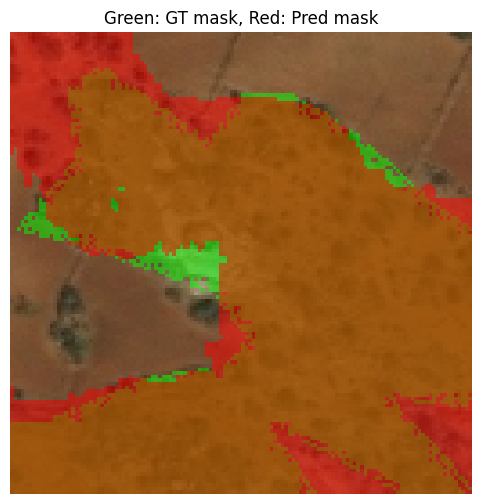

Epoch 13/20 | Train BCE: 0.398, Val BCE: 0.373, Train Dice: 0.184, Val Dice: 0.192, Train Combo: 0.582, Val Combo: 0.565, Train Acc: 0.823, Val Acc: 0.832, Train IoU: 0.760, Val IoU: 0.771)


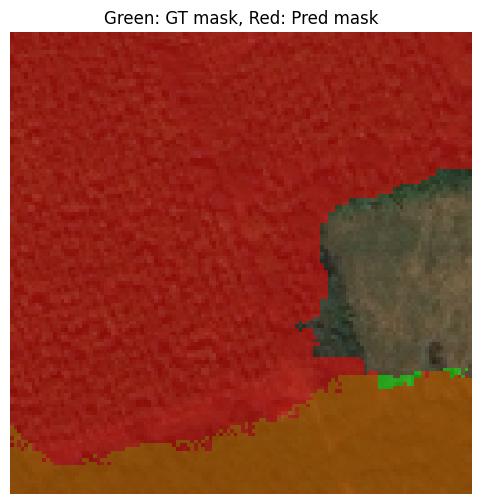

Epoch 14/20 | Train BCE: 0.397, Val BCE: 0.371, Train Dice: 0.184, Val Dice: 0.192, Train Combo: 0.581, Val Combo: 0.563, Train Acc: 0.824, Val Acc: 0.832, Train IoU: 0.761, Val IoU: 0.771)


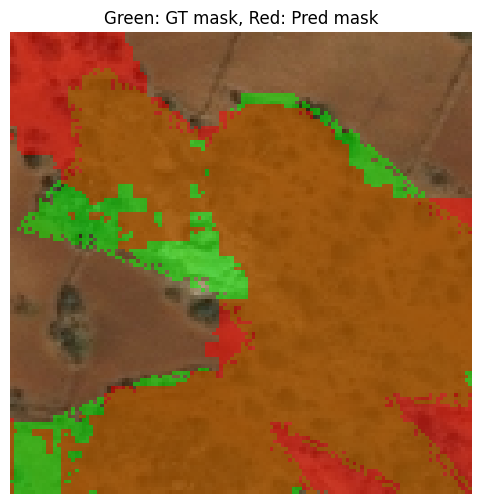

Epoch 15: Сохранили лучшую модель! Val Combo: 0.5481
Epoch 15/20 | Train BCE: 0.392, Val BCE: 0.379, Train Dice: 0.181, Val Dice: 0.169, Train Combo: 0.573, Val Combo: 0.548, Train Acc: 0.826, Val Acc: 0.833, Train IoU: 0.763, Val IoU: 0.775)


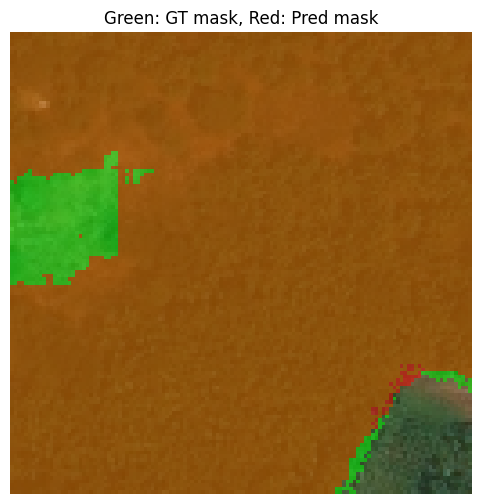

Epoch 16/20 | Train BCE: 0.393, Val BCE: 0.387, Train Dice: 0.182, Val Dice: 0.201, Train Combo: 0.575, Val Combo: 0.588, Train Acc: 0.825, Val Acc: 0.824, Train IoU: 0.762, Val IoU: 0.756)


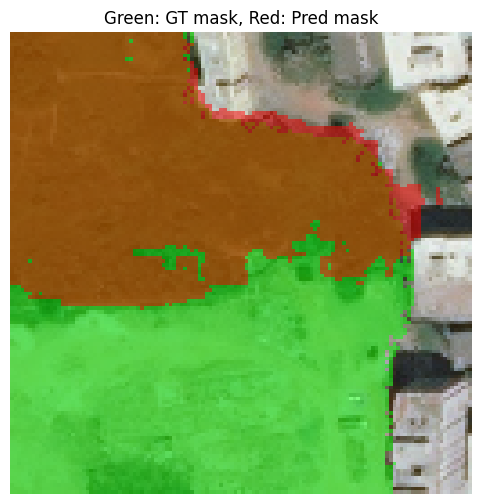

Epoch 17: Сохранили лучшую модель! Val Combo: 0.5462
Epoch 17/20 | Train BCE: 0.392, Val BCE: 0.372, Train Dice: 0.182, Val Dice: 0.175, Train Combo: 0.575, Val Combo: 0.546, Train Acc: 0.826, Val Acc: 0.834, Train IoU: 0.762, Val IoU: 0.777)


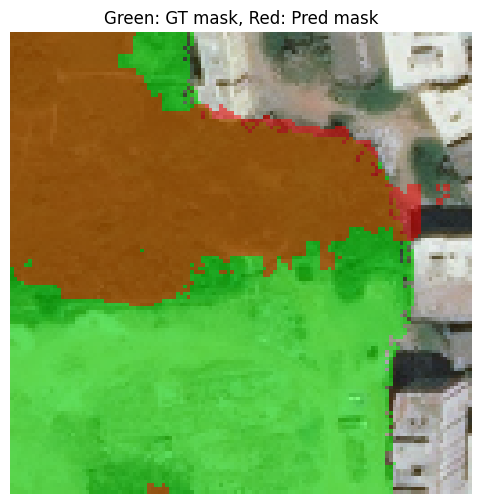

Epoch 18/20 | Train BCE: 0.393, Val BCE: 0.368, Train Dice: 0.181, Val Dice: 0.179, Train Combo: 0.574, Val Combo: 0.547, Train Acc: 0.827, Val Acc: 0.834, Train IoU: 0.763, Val IoU: 0.777)


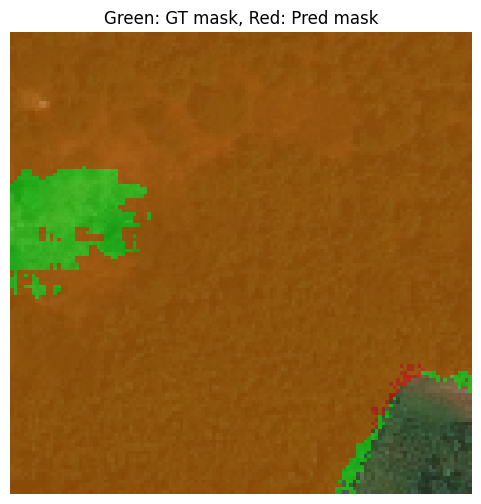

Epoch 19/20 | Train BCE: 0.391, Val BCE: 0.381, Train Dice: 0.182, Val Dice: 0.181, Train Combo: 0.573, Val Combo: 0.562, Train Acc: 0.827, Val Acc: 0.829, Train IoU: 0.762, Val IoU: 0.771)


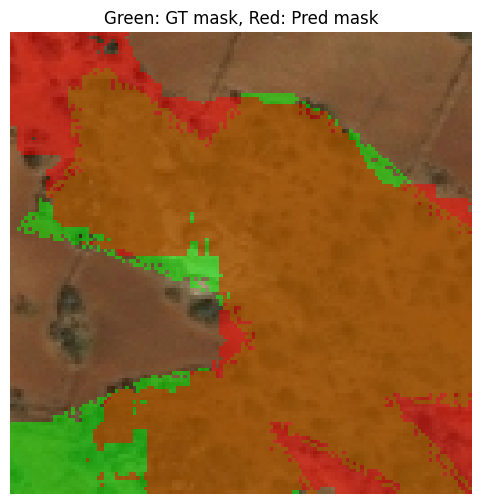

Epoch 20/20 | Train BCE: 0.392, Val BCE: 0.369, Train Dice: 0.181, Val Dice: 0.181, Train Combo: 0.573, Val Combo: 0.550, Train Acc: 0.826, Val Acc: 0.833, Train IoU: 0.763, Val IoU: 0.777)


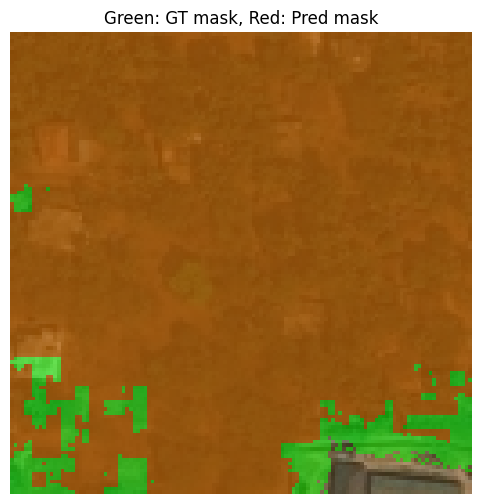

In [25]:
EPOCHS = 20  # например, продолжаем до 20 эпох
best_val_combo = float('inf')  # начальное значение для лучшей модели

for epoch in range(EPOCHS):
    # -------------------
    # TRAIN
    # -------------------
    model.train()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)

        bce = F.binary_cross_entropy(preds, masks)
        dice = DiceLoss()(preds, masks)
        combo = bce + dice

        optimizer.zero_grad()
        combo.backward()
        optimizer.step()

        batch_bce.append(bce.item())
        batch_dice.append(dice.item())
        batch_combo.append(combo.item())
        batch_acc.append(accuracy(preds, masks).item())
        batch_iou.append(iou(preds, masks).item())

    log["epoch_train_bce"].append(np.mean(batch_bce))
    log["epoch_train_dice"].append(np.mean(batch_dice))
    log["epoch_train_combo"].append(np.mean(batch_combo))
    log["epoch_train_accuracy"].append(np.mean(batch_acc))
    log["epoch_train_iou"].append(np.mean(batch_iou))

    # -------------------
    # VALID
    # -------------------
    model.eval()
    batch_bce, batch_dice, batch_combo = [], [], []
    batch_acc, batch_iou = [], []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            bce = F.binary_cross_entropy(preds, masks)
            dice = DiceLoss()(preds, masks)
            combo = bce + dice

            batch_bce.append(bce.item())
            batch_dice.append(dice.item())
            batch_combo.append(combo.item())
            batch_acc.append(accuracy(preds, masks).item())
            batch_iou.append(iou(preds, masks).item())

    val_combo_epoch = np.mean(batch_combo)

    log["epoch_valid_bce"].append(np.mean(batch_bce))
    log["epoch_valid_dice"].append(np.mean(batch_dice))
    log["epoch_valid_combo"].append(val_combo_epoch)
    log["epoch_valid_accuracy"].append(np.mean(batch_acc))
    log["epoch_valid_iou"].append(np.mean(batch_iou))

    # -------------------
    # Сохраняем лучшую модель
    # -------------------
    if val_combo_epoch < best_val_combo:
        best_val_combo = val_combo_epoch
        torch.save(model.state_dict(), f"checkpoints/best_unet2.pth")
        print(f"Epoch {epoch+1}: Сохранили лучшую модель! Val Combo: {best_val_combo:.4f}")

    # -------------------
    # PRINT
    # -------------------
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train BCE: {log['epoch_train_bce'][-1]:.3f}, Val BCE: {log['epoch_valid_bce'][-1]:.3f}, "
          f"Train Dice: {log['epoch_train_dice'][-1]:.3f}, Val Dice: {log['epoch_valid_dice'][-1]:.3f}, "
          f"Train Combo: {log['epoch_train_combo'][-1]:.3f}, Val Combo: {log['epoch_valid_combo'][-1]:.3f}, "
          f"Train Acc: {log['epoch_train_accuracy'][-1]:.3f}, Val Acc: {log['epoch_valid_accuracy'][-1]:.3f}, "
          f"Train IoU: {log['epoch_train_iou'][-1]:.3f}, Val IoU: {log['epoch_valid_iou'][-1]:.3f})")

    # Параметры нормализации, которые использовались в Albumentations
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    model.eval()
    with torch.no_grad():
        images_v, masks_v = next(iter(val_loader))
        images_v = images_v.to(device)
        masks_v = masks_v.to(device)
        preds_v = model(images_v)

    k = np.random.randint(0, images_v.size(0))

    # Де-нормализация изображения
    img = images_v[k].permute(1,2,0).cpu().numpy()
    img = (img * std[None,None,:] + mean[None,None,:])  # обратно к 0..1
    img = np.clip(img, 0, 1)

    # Маски
    mask_gt = masks_v[k].squeeze().cpu().numpy()       # 0 или 1
    mask_pr = (preds_v[k].squeeze().cpu().numpy() > 0.5).astype(np.uint8)

    # Создаем RGB overlay
    overlay = img.copy()

    alpha = 0.5
    # Зеленым накладываем GT
    overlay[mask_gt==1] = (1-alpha)*overlay[mask_gt==1] + alpha*np.array([0,1,0])

    # Красным накладываем Pred
    overlay[mask_pr==1] = (1-alpha)*overlay[mask_pr==1] + alpha*np.array([1,0,0])

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Green: GT mask, Red: Pred mask")
    plt.show()

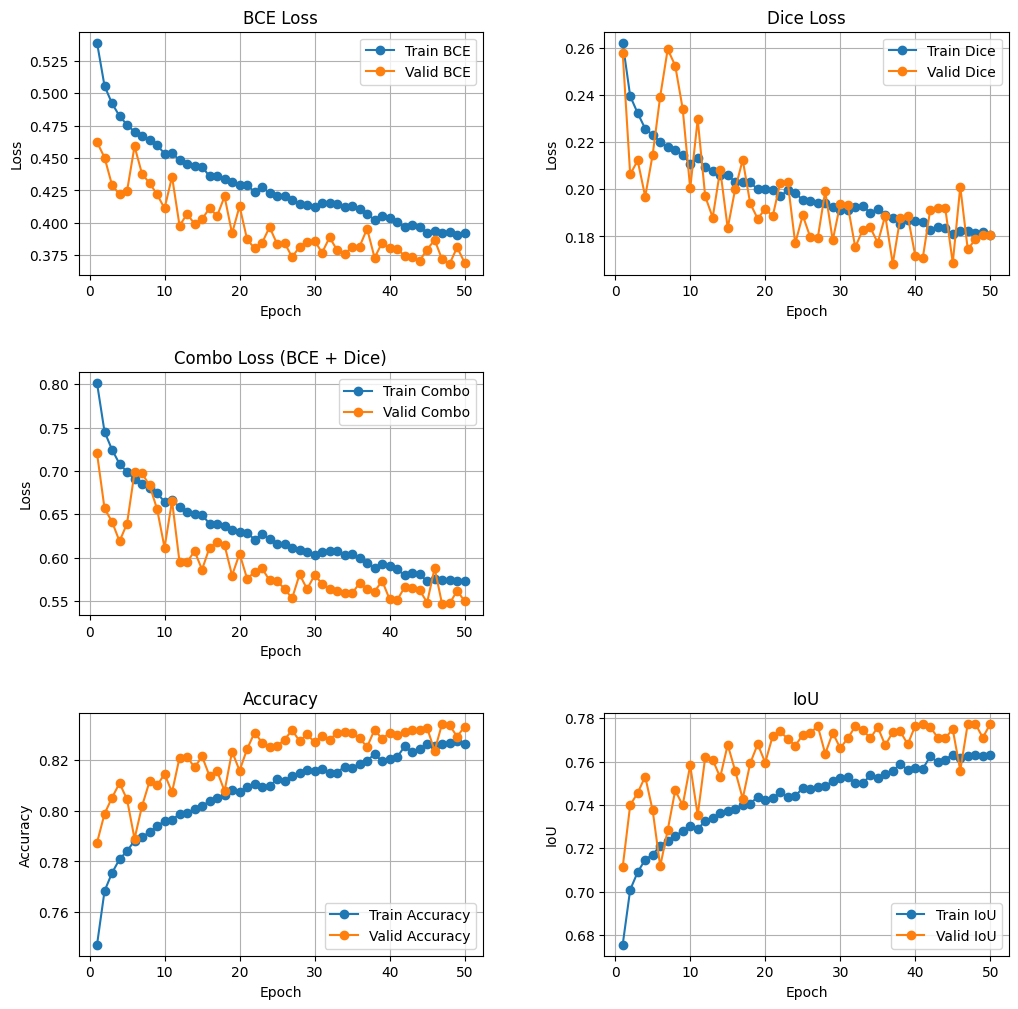

In [26]:
epochs = range(1, len(log['epoch_train_bce']) + 1)

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# -----------------------------
# 1 строка: BCE и Dice
# -----------------------------
# BCE
axes[0, 0].plot(epochs, log['epoch_train_bce'], label='Train BCE', marker='o')
axes[0, 0].plot(epochs, log['epoch_valid_bce'], label='Valid BCE', marker='o')
axes[0, 0].set_title("BCE Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Dice
axes[0, 1].plot(epochs, log['epoch_train_dice'], label='Train Dice', marker='o')
axes[0, 1].plot(epochs, log['epoch_valid_dice'], label='Valid Dice', marker='o')
axes[0, 1].set_title("Dice Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(True)

# -----------------------------
# 2 строка: Combo (занимает всю строку)
# -----------------------------
# Чтобы занять всю строку, объединим два графика axes[1,0] и axes[1,1]
fig.delaxes(axes[1,1])  # удаляем пустой график справа
axes[1,0].plot(epochs, log['epoch_train_combo'], label='Train Combo', marker='o')
axes[1,0].plot(epochs, log['epoch_valid_combo'], label='Valid Combo', marker='o')
axes[1,0].set_title("Combo Loss (BCE + Dice)")
axes[1,0].set_xlabel("Epoch")
axes[1,0].set_ylabel("Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# -----------------------------
# 3 строка: Accuracy и IoU
# -----------------------------
# Accuracy
axes[2, 0].plot(epochs, log['epoch_train_accuracy'], label='Train Accuracy', marker='o')
axes[2, 0].plot(epochs, log['epoch_valid_accuracy'], label='Valid Accuracy', marker='o')
axes[2, 0].set_title("Accuracy")
axes[2, 0].set_xlabel("Epoch")
axes[2, 0].set_ylabel("Accuracy")
axes[2, 0].legend()
axes[2, 0].grid(True)

# IoU
axes[2, 1].plot(epochs, log['epoch_train_iou'], label='Train IoU', marker='o')
axes[2, 1].plot(epochs, log['epoch_valid_iou'], label='Valid IoU', marker='o')
axes[2, 1].set_title("IoU")
axes[2, 1].set_xlabel("Epoch")
axes[2, 1].set_ylabel("IoU")
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.show()

In [27]:
model.load_state_dict(torch.load("checkpoints/best_unet2.pth"))  # или unet_last_epoch.pth
model.eval()

UNet(
  (down1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

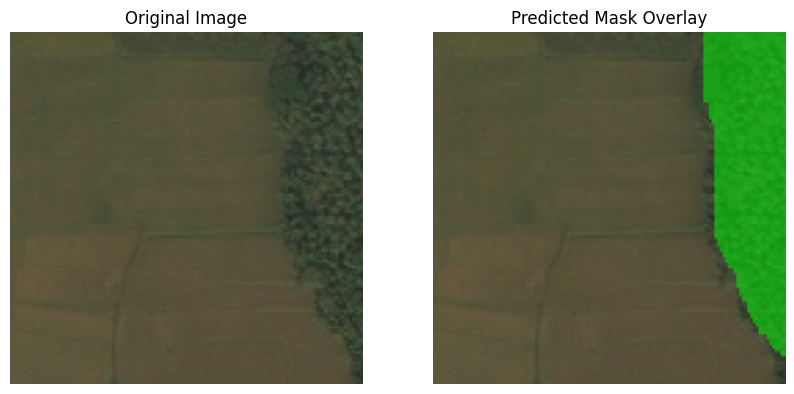

In [28]:
transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(),
    ToTensorV2()
])

# Читаем изображение
img_orig = cv2.imread("10452_sat_08.jpg")
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

# Применяем трансформацию
augmented = transform(image=img_orig)
img_tensor = augmented["image"].unsqueeze(0).to(device)

# --- Предсказание ---
with torch.no_grad():
    pred_mask = model(img_tensor)[0,0].cpu().numpy()
    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

# --- Де-нормализация изображения для визуализации ---
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img_vis = img_tensor[0].permute(1,2,0).cpu().numpy()
img_vis = (img_vis * std + mean)
img_vis = np.clip(img_vis, 0, 1)

# --- Создаем overlay с прозрачной зелёной маской ---
overlay = img_vis.copy()
alpha = 0.5
overlay[pred_mask_bin==1] = (1-alpha)*overlay[pred_mask_bin==1] + alpha*np.array([0,1,0])

# --- Вывод ---
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_vis)
plt.axis("off")
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.axis("off")
plt.title("Predicted Mask Overlay")
plt.show()

In [23]:
# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Device:", device)
# if device.type == "cuda":
#     print("GPU:", torch.cuda.get_device_name(0))

# # Импортируем train_loader, val_loader и модель (UNet)
# # Предполагаем, что train_loader уже создан
# model = UNet().to(device)

# # Проверка одного батча из train_loader
# try:
#     images, masks = next(iter(train_loader))
#     print("Images batch shape:", images.shape)
#     print("Masks batch shape:", masks.shape)

#     images, masks = images.to(device), masks.to(device)
#     with torch.no_grad():
#         preds = model(images)
#     print("Preds batch shape:", preds.shape)

#     # Мини-лоссы и метрики
#     import torch.nn.functional as F

#     bce = F.binary_cross_entropy(preds, masks)
#     dice = DiceLoss()(preds, masks)
#     combo = bce + dice
#     print(f"BCE: {bce.item():.4f}, Dice: {dice.item():.4f}, Combo: {combo.item():.4f}")

# except Exception as e:
#     print("Ошибка при тесте батча:", e)

Device: cpu
Images batch shape: torch.Size([8, 3, 128, 128])
Masks batch shape: torch.Size([8, 1, 128, 128])
Preds batch shape: torch.Size([8, 1, 128, 128])
BCE: 0.7504, Dice: 0.4452, Combo: 1.1956
